In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import time
import pandas as pd
import numpy as np

from tqdm import tqdm
from multiprocessing import Pool

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, confusion_matrix, precision_recall_curve

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense, Dropout, Flatten, Activation, Conv2D, MaxPool2D
from tensorflow.keras import Model, Input, Sequential

In [3]:
RANDOM_STATE = 35

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def plot_metric(history, metric,  label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history[metric],
               color=colors[n], label='Train ' + label)
  if metric != "lr":
    plt.semilogy(history.epoch, history.history[f'val_{metric}'],
                color=colors[n], label='Val ' + label,
                linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.legend()

In [5]:
def compare_models(X, Y, classifiers=None, indices_split=None, scaling=None):
    """
    Args:
    
    X, Y - if calssifiers == None and indices_split == None, X and Y are tuples
    that contains (X_train, X_val) e (Y_train, Y_test), otherwise X, Y
    are np.array of all dataset to be separeted using the indices_split
    into n fold.
    classifiers - dictionary of classifiers or a single classifier.
    
    
    """
    history = {}
    
    if indices_split and classifiers:

        for clf_name, clf, (train, val) in zip(classifiers.keys(), classifiers.values(), indices_split.values()):

            print(f"\n Evaluating the model {clf_name}")
            
            if scaling:
                scaler = MinMaxScaler()
                X_train = scaler.fit_transform(X[train])
                X_val = scaler.transform(X[val])

            #Training 

            y_hat_train = clf.predict(X_train)

            rf_train_roc_auc_score = roc_auc_score(Y[train], y_hat_train)
            rf_train_f1_score = f1_score(Y[train], y_hat_train, average="weighted")

            #val

            y_hat_val = clf.predict(X_val)

            rf_val_roc_auc_score = roc_auc_score(Y[val], y_hat_val)
            rf_val_f1_score = f1_score(Y[val], y_hat_val, average="weighted")
            precision, recall, thresholds_pr = precision_recall_curve(Y[val], y_hat_val)
            AUC_PRcurve= auc(recall, precision)
            fpr, tpr, thresholds = roc_curve(Y[val], y_hat_val)

            print(f"F1 score - Train: {rf_train_f1_score} / val: {rf_val_f1_score}")
            print(f"ROC AUC score - Train: {rf_train_roc_auc_score} / val: {rf_val_roc_auc_score}")
            print(f"PR AUC score - val: {AUC_PRcurve}")

            history[clf_name] = {"y_hat_train": y_hat_train, "y_hat_val": y_hat_val,
                                 "pr": (precision, recall, AUC_PRcurve), "roc": (fpr, tpr, thresholds)}
    else:
        clf = classifiers
        #Train
        X_train, X_val = X
        y_train, y_val = Y
        
        if scaling:
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.fit(X_val)
        
        if X_train is not None:

            y_hat_train = clf.predict(X_train)

            rf_train_roc_auc_score = roc_auc_score(y_train, y_hat_train)
            rf_train_f1_score = f1_score(y_train, y_hat_train, average="weighted")

        #val

        y_hat_val = clf.predict(X_val)

        rf_val_roc_auc_score = roc_auc_score(y_val, y_hat_val)
        rf_val_f1_score = f1_score(y_val, y_hat_val, average="weighted")
        precision, recall, thresholds_pr = precision_recall_curve(y_val, y_hat_val)
        AUC_PRcurve= auc(recall, precision)
        fpr, tpr, thresholds = roc_curve(y_val, y_hat_val)
        
        if X_train is not None:
            print(f"F1 score - Train: {rf_train_f1_score} / val: {rf_val_f1_score}")
            print(f"ROC AUC score - Train: {rf_train_roc_auc_score} / val: {rf_val_roc_auc_score}")
            print(f"PR AUC score - val: {AUC_PRcurve}")
        else:
            y_hat_val = clf.predict(X_val)

            rf_val_roc_auc_score = roc_auc_score(y_val, y_hat_val)
            rf_val_f1_score = f1_score(y_val, y_hat_val, average="weighted")
            precision, recall, thresholds_pr = precision_recall_curve(y_val, y_hat_val)
            AUC_PRcurve= auc(recall, precision)
            fpr, tpr, thresholds = roc_curve(y_val, y_hat_val)
            
            print(f"ROC AUC score val: {rf_val_roc_auc_score}")
            print(f"PR AUC score val: {AUC_PRcurve}")
            
            history["clf_0"] = {"y_hat_test": y_hat_val,
                                       "pr": (precision, recall, AUC_PRcurve), 
                                       "roc": (fpr, tpr, thresholds)}
            
            return history
            

        history["clf_0"] = {"y_hat_train": y_hat_train, "y_hat_val": y_hat_val,
                            "pr": (precision, recall, AUC_PRcurve), "roc": (fpr, tpr, thresholds)}
        
    return history

In [6]:
def plot_pr_curve(history):
    
    i = 0
    for model_name, model_eval in zip(history.keys(), history.values()):
    
        precision, recall, AUC_PRcurve = model_eval["pr"]
    
        # plot no skill
        plt.plot([0, 1], [0.5, 0.5], linestyle='--')
        #plot PR curve
        plt.plot(precision, recall, label = "{} AUC = {:0.2f}".format(model_name, AUC_PRcurve), lw = 3, alpha = 0.7, color=colors[i])

        i += 1
    plt.xlabel('Precision', fontsize = 14)
    plt.ylabel('Recall', fontsize = 14)
    plt.title('Precision-Recall Curve', fontsize = 18)
    plt.legend(loc='best')

# Preprocessing

In [7]:
data_ts = pd.read_csv("/content/drive/MyDrive/Documents/programacao/stone/desafio/processed_features.csv")

data_ts.head()


,account_id,device_id,balance,processed_at,is_fraud,age_range,number_of_selfies_sent,time_client,cash_out_type_1,cash_out_type_2,cash_out_type_3,cash_out_type_6
0,0,0,0.000167,1.542826e+09,0,0.0,5.0,8.783463e+05,1,0,0,0
1,1,0,0.000533,1.540263e+09,0,1.0,5.0,9.689721e+06,0,0,1,0
2,1,0,0.000347,1.542655e+09,0,1.0,5.0,1.208182e+07,0,0,1,0
3,1,0,0.000572,1.540837e+09,0,1.0,5.0,1.026435e+07,0,0,1,0
4,1,0,0.000346,1.540998e+09,0,1.0,5.0,1.042547e+07,0,0,1,0


In [8]:
columns=['account_id', 'is_fraud', 'device_id', 'balance', 'processed_at',
       'age_range', 'number_of_selfies_sent', 'time_client', 'cash_out_type_1',
       'cash_out_type_2', 'cash_out_type_3', 'cash_out_type_6']

data_ts = data_ts[columns]

data_ts.head()

,account_id,is_fraud,device_id,balance,processed_at,age_range,number_of_selfies_sent,time_client,cash_out_type_1,cash_out_type_2,cash_out_type_3,cash_out_type_6
0,0,0,0,0.000167,1.542826e+09,0.0,5.0,8.783463e+05,1,0,0,0
1,1,0,0,0.000533,1.540263e+09,1.0,5.0,9.689721e+06,0,0,1,0
2,1,0,0,0.000347,1.542655e+09,1.0,5.0,1.208182e+07,0,0,1,0
3,1,0,0,0.000572,1.540837e+09,1.0,5.0,1.026435e+07,0,0,1,0
4,1,0,0,0.000346,1.540998e+09,1.0,5.0,1.042547e+07,0,0,1,0


In [9]:
data_ts.dtypes

account_id                  int64
is_fraud                    int64
device_id                   int64
balance                   float64
processed_at              float64
age_range                 float64
number_of_selfies_sent    float64
time_client               float64
cash_out_type_1             int64
cash_out_type_2             int64
cash_out_type_3             int64
cash_out_type_6             int64
dtype: object

In [10]:
# the columns that pass the float16 limite, we gonna take them and turn and something
# that we can work using min max scaler

max_account = data_ts["account_id"].max()
max_device_id = data_ts["device_id"].max()
max_processed_at = data_ts["processed_at"].max()
max_time_client = data_ts["time_client"].max()

data_ts["account_id"] = data_ts["account_id"] / max_account
data_ts["device_id"] = data_ts["device_id"] / max_device_id
data_ts["processed_at"] = data_ts["processed_at"] / max_processed_at
data_ts["time_client"] = data_ts["time_client"] / max_time_client

# seconds to days

data_ts.time_client = data_ts.time_client / (60*60*24)

data_ts.head()


,account_id,is_fraud,device_id,balance,processed_at,age_range,number_of_selfies_sent,time_client,cash_out_type_1,cash_out_type_2,cash_out_type_3,cash_out_type_6
0,0.000000,0,0.0,0.000167,0.999813,0.0,5.0,1.785904e-07,1,0,0,0
1,0.000016,0,0.0,0.000533,0.998152,1.0,5.0,1.970170e-06,0,0,1,0
2,0.000016,0,0.0,0.000347,0.999702,1.0,5.0,2.456546e-06,0,0,1,0
3,0.000016,0,0.0,0.000572,0.998524,1.0,5.0,2.087007e-06,0,0,1,0
4,0.000016,0,0.0,0.000346,0.998629,1.0,5.0,2.119767e-06,0,0,1,0


In [11]:
data_ts.corr()

,account_id,is_fraud,device_id,balance,processed_at,age_range,number_of_selfies_sent,time_client,cash_out_type_1,cash_out_type_2,cash_out_type_3,cash_out_type_6
account_id,1.000000,-0.031733,0.936605,-0.115446,0.030805,0.014728,-0.011119,-0.124930,-0.024468,0.314274,-0.312839,0.001893
is_fraud,-0.031733,1.000000,-0.032270,-0.002463,-0.006212,0.001232,0.000773,-0.001799,0.005346,0.017931,-0.019762,-0.000132
device_id,0.936605,-0.032270,1.000000,-0.120909,0.030237,0.010916,-0.010421,-0.128533,-0.021081,0.339309,-0.339272,0.001675
balance,-0.115446,-0.002463,-0.120909,1.000000,0.013672,0.041070,-0.015854,0.278847,0.019471,0.036898,-0.043073,-0.000271
processed_at,0.030805,-0.006212,0.030237,0.013672,1.000000,0.005170,-0.010542,0.034895,-0.000934,0.011392,-0.011319,-0.001043
age_range,0.014728,0.001232,0.010916,0.041070,0.005170,1.000000,-0.008867,-0.025235,0.002038,0.043571,-0.044924,0.001572
number_of_selfies_sent,-0.011119,0.000773,-0.010421,-0.015854,-0.010542,-0.008867,1.000000,0.134589,0.006826,-0.008444,0.006654,-0.000253
time_client,-0.124930,-0.001799,-0.128533,0.278847,0.034895,-0.025235,0.134589,1.000000,0.014227,-0.022264,0.018509,0.014154
cash_out_type_1,-0.024468,0.005346,-0.021081,0.019471,-0.000934,0.002038,0.006826,0.014227,1.000000,-0.200642,-0.079909,-0.000421
cash_out_type_2,0.314274,0.017931,0.339309,0.036898,0.011392,0.043571,-0.008444,-0.022264,-0.200642,1.000000,-0.960473,-0.005063


In [12]:
size_pos = len(data_ts[data_ts.is_fraud==1])
size_neg = len(data_ts[data_ts.is_fraud==0])

post_proportion =  size_pos/ (size_neg + size_pos)

post_proportion

0.0016313560447852402

# Encoder decoder model

In [13]:
Y = np.array(data_ts.copy().pop("is_fraud"), dtype=np.float32)

#droping the target and the features weakly correlated to the target
data_enco_deco = data_ts.copy().drop(["is_fraud", "account_id", "processed_at", "number_of_selfies_sent", "cash_out_type_6"], axis=1)

display(data_enco_deco.head())

train, val = train_test_split(data_enco_deco, test_size=0.1)

X_train = np.array(train, dtype=np.float32)
Y_train = np.array(train, dtype=np.float32)

X_val = np.array(val, dtype=np.float32)
Y_val = np.array(val, dtype=np.float32)

X_train.shape

,device_id,balance,age_range,time_client,cash_out_type_1,cash_out_type_2,cash_out_type_3
0,0.0,0.000167,0.0,1.785904e-07,1,0,0
1,0.0,0.000533,1.0,1.970170e-06,0,0,1
2,0.0,0.000347,1.0,2.456546e-06,0,0,1
3,0.0,0.000572,1.0,2.087007e-06,0,0,1
4,0.0,0.000346,1.0,2.119767e-06,0,0,1


(846841, 7)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_MSE', 
    verbose=1,
    patience=40,
    mode='max',
    restore_best_weights=True)

def scheduler(epoch, lr):
  if epoch % 10 == 0:
    return lr * tf.math.exp(-2.)
  else:
    return lr

In [15]:
def model(X):

  input = Input(X.shape[-1])
  X = Dense(6, activation="relu")(input)
  X = BatchNormalization()(X)
  encode = Dense(4, activation="relu")(X)
  X = BatchNormalization()(encode)
  X = Dense(6, activation="relu")(X)
  X = BatchNormalization()(X)
  output = Dense(7, activation="relu")(X)

  model = Model(inputs=input, outputs=output, name="full_model")
  bottleneck = Model(input, encode, name="bottleneck")


  model.summary()
  bottleneck.summary()

  return model, bottleneck


In [16]:
tf.keras.backend.clear_session()

In [17]:
batch_size = 1024
epochs = 100
validation_batch_size = None
validation_steps = None
workers = -1
use_multiprocessing=True
steps_per_epoch = None
validation_steps = None
initial_learning_rate = 1e-1

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

metrics = [
           tf.keras.metrics.MeanSquaredError(name="MSE"),
           tf.keras.metrics.MeanAbsoluteError(name="MAE")
           ]

In [18]:
full_model, bottleneck = model(X_train)

full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=metrics
  )

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 6)                 48        
                                                                 
 batch_normalization (BatchN  (None, 6)                24        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 4)                 28        
                                                                 
 batch_normalization_1 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 6)                 3

In [19]:

history_encode = full_model.fit(
    x=X_train, y=Y_train, batch_size=batch_size, epochs=600, verbose='auto', 
    validation_data=(X_val, Y_val), shuffle=True, 
    steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
    validation_batch_size=validation_batch_size,
    workers=workers, use_multiprocessing=use_multiprocessing, 
    callbacks=[lr_callback, early_stopping]
)


Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.013533528, shape=(), dtype=float32).
Epoch 1/600
827/827 [==============================] - 4s 4ms/step - loss: 0.0146 - MSE: 0.0146 - MAE: 0.0394 - val_loss: 0.0064 - val_MSE: 0.0064 - val_MAE: 0.0260 - lr: 0.0135

Epoch 00002: LearningRateScheduler setting learning rate to 0.013533527962863445.
Epoch 2/600
827/827 [==============================] - 3s 3ms/step - loss: 0.0058 - MSE: 0.0058 - MAE: 0.0225 - val_loss: 0.0102 - val_MSE: 0.0102 - val_MAE: 0.0402 - lr: 0.0135

Epoch 00003: LearningRateScheduler setting learning rate to 0.013533527962863445.
Epoch 3/600
827/827 [==============================] - 3s 3ms/step - loss: 0.0056 - MSE: 0.0056 - MAE: 0.0217 - val_loss: 0.0067 - val_MSE: 0.0067 - val_MAE: 0.0295 - lr: 0.0135

Epoch 00004: LearningRateScheduler setting learning rate to 0.013533527962863445.
Epoch 4/600
827/827 [==============================] - 3s 3ms/step - loss: 0.0056 - MSE: 0.0056 - MAE: 0.02

In [20]:
full_model.save('saved_model/encoder_decoder')
bottleneck.save('saved_model/bottleneck')

INFO:tensorflow:Assets written to: saved_model/encoder_decoder/assets
INFO:tensorflow:Assets written to: saved_model/bottleneck/assets


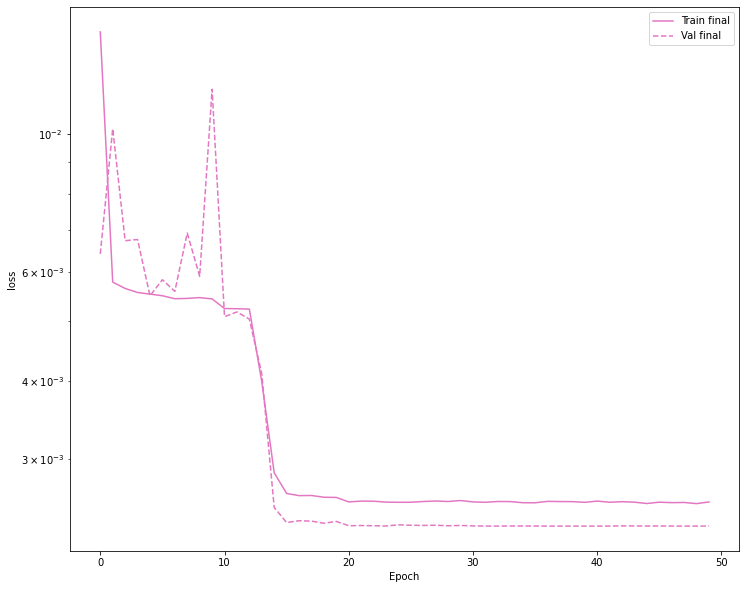

In [21]:
plot_metric(history_encode, "loss",  "final", 6)

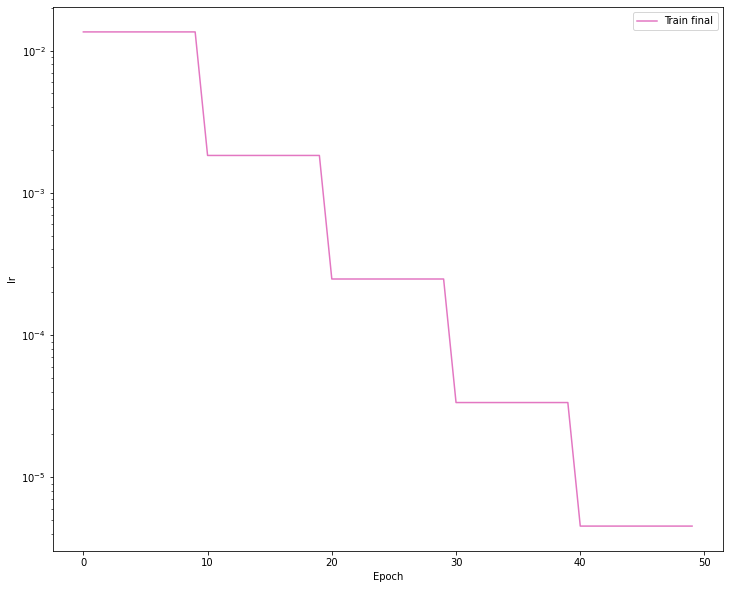

In [22]:
plot_metric(history_encode, "lr",  "final", 6)

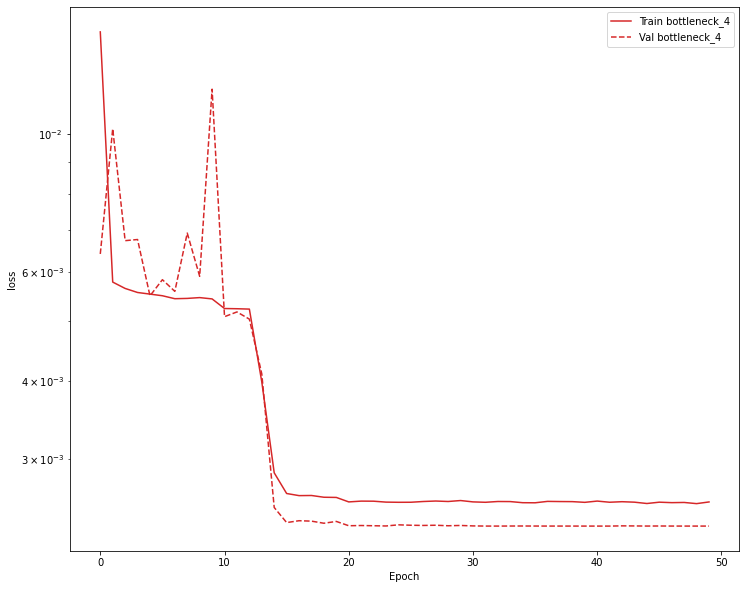

In [23]:
plt.figure()
plot_metric(history_encode, "loss",  "bottleneck_4", 3)
plt.show
plt.savefig("loss.png")


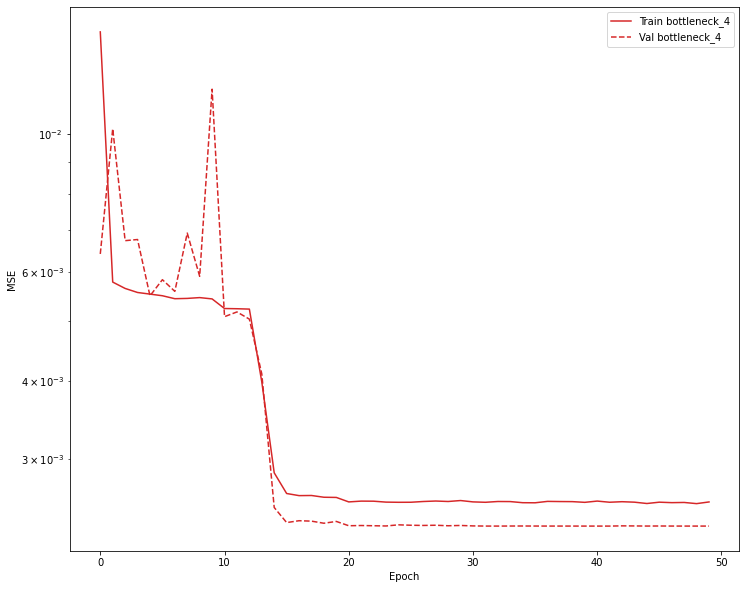

In [24]:
plt.figure()
plot_metric(history_encode, "MSE",  "bottleneck_4", 3)
plt.show
plt.savefig("mse.png")


In [25]:
to_encode = np.array(data_enco_deco, dtype=np.float32)

encoded = bottleneck.predict(to_encode)

encoded.shape

(940935, 4)

In [26]:
df_encoded = pd.DataFrame(to_encode)
df_encoded.insert(0, "is_fraud", Y)

df_encoded.corr()

,is_fraud,0,1,2,3,4,5,6
is_fraud,1.000000,-0.032270,-0.002463,0.001232,-0.001799,0.005346,0.017931,-0.019762
0,-0.032270,1.000000,-0.120909,0.010916,-0.128533,-0.021081,0.339309,-0.339272
1,-0.002463,-0.120909,1.000000,0.041070,0.278847,0.019471,0.036898,-0.043073
2,0.001232,0.010916,0.041070,1.000000,-0.025235,0.002038,0.043571,-0.044924
3,-0.001799,-0.128533,0.278847,-0.025235,1.000000,0.014227,-0.022264,0.018509
4,0.005346,-0.021081,0.019471,0.002038,0.014227,1.000000,-0.200642,-0.079909
5,0.017931,0.339309,0.036898,0.043571,-0.022264,-0.200642,1.000000,-0.960473
6,-0.019762,-0.339272,-0.043073,-0.044924,0.018509,-0.079909,-0.960473,1.000000


In [27]:
Y.shape

(940935,)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (roc_auc_score, f1_score, roc_curve, auc, 
                             confusion_matrix, precision_recall_curve, make_scorer)


features_train, features_val, labels_train, labels_val = train_test_split(encoded,  Y, test_size = 0.01,  stratify=Y)
features_train, features_test, labels_train, labels_test = train_test_split(features_train,  labels_train, test_size = 0.01,  stratify=labels_train)

print(features_train.shape)

clf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs= 3,
                            class_weight= "balanced_subsample", min_samples_leaf= 2, 
                            verbose=1, oob_score=True)

clf.fit(features_train, labels_train)

(922209, 4)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  3.3min finished


RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                       n_jobs=3, oob_score=True, random_state=35, verbose=1)

In [29]:
X_pack = features_train, features_val
Y_pack = labels_train, labels_val

history_5 = compare_models(X_pack, Y_pack, clf)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    8.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.1s finished


F1 score - Train: 0.9995456189781546 / val: 0.9993822721197899
ROC AUC score - Train: 0.9997567079104684 / val: 0.9331204541422743
PR AUC score - val: 0.815792544435415


<function matplotlib.pyplot.show>

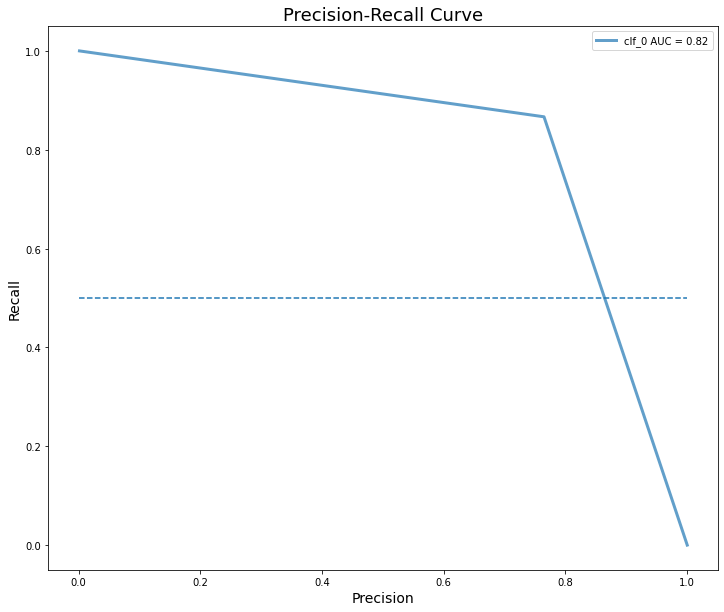

In [30]:
#history_4, history_5
plt.figure()
plot_pr_curve(history_5)
plt.show

In [31]:
X_pack_test = None, features_test
Y_pack_test = None, labels_test

history_test = compare_models(X_pack_test, Y_pack_test, clf)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.1s finished


ROC AUC score val: 0.8663978783643337
PR AUC score val: 0.7106313510805782


In [32]:
!zip -r /content/saved_model.zip /content/saved_model

updating: content/saved_model/ (stored 0%)
updating: content/saved_model/bottleneck/ (stored 0%)
updating: content/saved_model/bottleneck/variables/ (stored 0%)
updating: content/saved_model/bottleneck/variables/variables.data-00000-of-00001 (deflated 59%)
updating: content/saved_model/bottleneck/variables/variables.index (deflated 49%)
updating: content/saved_model/bottleneck/saved_model.pb (deflated 88%)
updating: content/saved_model/bottleneck/keras_metadata.pb (deflated 88%)
updating: content/saved_model/bottleneck/assets/ (stored 0%)
updating: content/saved_model/.ipynb_checkpoints/ (stored 0%)
updating: content/saved_model/encoder_decoder/ (stored 0%)
updating: content/saved_model/encoder_decoder/variables/ (stored 0%)
updating: content/saved_model/encoder_decoder/variables/variables.data-00000-of-00001 (deflated 66%)
updating: content/saved_model/encoder_decoder/variables/variables.index (deflated 71%)
updating: content/saved_model/encoder_decoder/saved_model.pb (deflated 90%)
u

In [33]:
from google.colab import files
files.download("/content/saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>